# PREDICCIÓN DEL GRUPO DE NÚMERO DE ESPECIES Y CAPTURAS

## IMPORTACIÓN DE LIBRERÍAS Y DEFINICIÓN DE FUNCIONES

In [ ]:
#Importación de librerías necesarias:
import io
import numpy as np
import pandas as pd
import seaborn as sns

from google.colab import files

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (25,10)

from sklearn import preprocessing
from pandas.plotting import scatter_matrix
#from scipy.stats.stats import pearsonr
from scipy.stats import pearsonr
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

#Random_state:
rs = 0

In [ ]:
# #Comprobación de versiones:
# !python3 -m pip list

## CARGA DE DATOS

- Alternativa 1: Conectando con Google Drive y abriendo el fichero desde el mismo:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/D2_NumCapturas.csv', delimiter = ';', encoding='latin-1', decimal=',')
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/D2_NumCapturas_2.csv', delimiter = ';', encoding='latin-1', decimal=',')
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/D2_NumCapturas_3.csv', delimiter=';', encoding='latin-1', decimal=',')
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/D2_NumCapturas_4.csv', delimiter=';', encoding='latin-1', decimal=',')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/D2_NumCapturas_5.csv', delimiter=';', encoding='latin-1', decimal=',')
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/D2_NumCapturas_IdBuque.csv', delimiter = ';', encoding='latin-1', decimal=',')
df.head()

,Año,Mes,SemanaAño,IdArteCategoria,GrupoRE,GrupoEslora,IdCenso,IdProvincia,IdTipoCombustible,Potencia,PesoTotalCapturado,GrupoNumEspecies,GrupoNumCapturas
0,2022,9,36,5,2,1,3,33,1,58.83990,110.0,1,2
1,2018,1,2,3,2,3,2,15,1,297.87699,765.0,2,1
2,2018,2,6,3,1,3,2,15,1,297.87699,4448.0,2,4
3,2018,4,17,3,1,3,2,15,1,110.32481,7586.0,2,4
4,2018,5,18,3,1,4,2,15,1,205.93965,6000.0,1,1


In [ ]:
#Se elimina el campo PesoTotalCapturado:
# df = df.drop('PesoTotalCapturado',axis=1)
# df.head()

- Alternativa 2: Subiendo fichero a Google Colab:

In [ ]:
# #Definiendo una función que permita cargar los datos desde una ubicación seleccionada:
# def upload_files ():
#   uploaded = files.upload()
#   for fn in uploaded.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(
#         name=fn, length=len(uploaded[fn])))
#     df = pd.read_csv(io.StringIO(uploaded[fn].decode('latin-1')),delimiter=';',decimal=',')
#     return df

# df = upload_files()

# #Muestra del dataset:
# df.head()

- Alternativa 3: Fichero ya subido a Google Colab:

In [ ]:
# df = pd.read_csv('D2_NumCapturas_5.csv',encoding='latin-1',delimiter=';',decimal=',')
# df.head()

## EXPLORACIÓN

#### Dimensiones y tipología de datos

In [ ]:
#Dimensiones dataset:
df.shape

(88275, 13)

In [ ]:
#Tipología de datos:
df.dtypes

Año                     int64
Mes                     int64
SemanaAño               int64
IdArteCategoria         int64
GrupoRE                 int64
GrupoEslora             int64
IdCenso                 int64
IdProvincia             int64
IdTipoCombustible       int64
Potencia              float64
PesoTotalCapturado    float64
GrupoNumEspecies        int64
GrupoNumCapturas        int64
dtype: object

#### Missing values

In [ ]:
#Evaluación de valores nulos:
pd.isnull(df).sum()

Año                   0
Mes                   0
SemanaAño             0
IdArteCategoria       0
GrupoRE               0
GrupoEslora           0
IdCenso               0
IdProvincia           0
IdTipoCombustible     0
Potencia              0
PesoTotalCapturado    0
GrupoNumEspecies      0
GrupoNumCapturas      0
dtype: int64

In [ ]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Año - 0%
Mes - 0%
SemanaAño - 0%
IdArteCategoria - 0%
GrupoRE - 0%
GrupoEslora - 0%
IdCenso - 0%
IdProvincia - 0%
IdTipoCombustible - 0%
Potencia - 0%
PesoTotalCapturado - 0%
GrupoNumEspecies - 0%
GrupoNumCapturas - 0%


In [ ]:
#Eliminación de las instancias con missing values:
df = df.dropna()

####  Matriz de correlación

<Axes: >

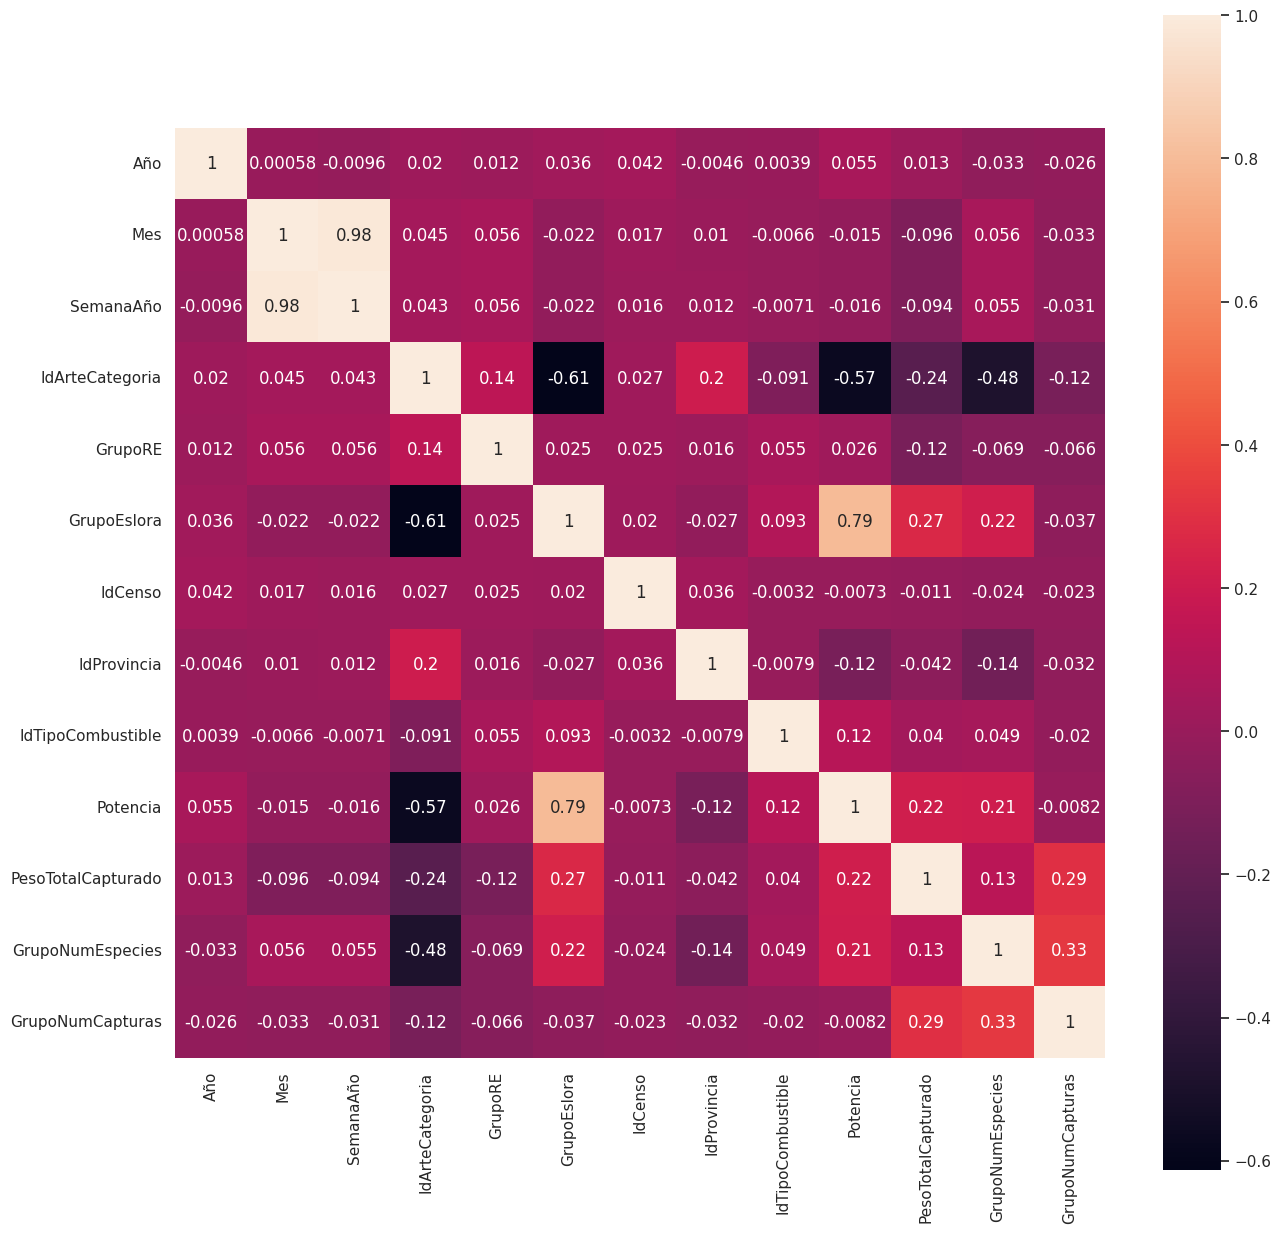

In [ ]:
#Matriz de correlación de las variables numéricas (para ver cuáles de ellas están fuertemente relacionadas):
sns.set()
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), square=True, annot=True)

#### Balanceo de datos

In [ ]:
#¿Datos balanceados?
print(df.groupby('Año').size().sort_values())
print('#---------------------------#')
print(df.groupby('Mes').size().sort_values())
print('#---------------------------#')
print(df.groupby('SemanaAño').size().sort_values())
print('#---------------------------#')
print(df.groupby('IdArteCategoria').size().sort_values())
print('#---------------------------#')
print(df.groupby('GrupoRE').size().sort_values())
print('#---------------------------#')
print(df.groupby('GrupoEslora').size().sort_values())
print('#---------------------------#')
print(df.groupby('IdCenso').size().sort_values())
print('#---------------------------#')
print(df.groupby('IdProvincia').size().sort_values())
print('#---------------------------#')
print(df.groupby('IdTipoCombustible').size().sort_values())
print('#---------------------------#')
print(df.groupby('Potencia').size().sort_values())
print('#---------------------------#')
print(df.groupby('PesoTotalCapturado').size().sort_values())
print('#---------------------------#')
print(df.groupby('GrupoNumEspecies').size().sort_values())
print('#---------------------------#')
print(df.groupby('GrupoNumCapturas').size().sort_values())

Año
2019    16737
2022    17512
2018    17940
2020    17941
2021    18145
dtype: int64
#---------------------------#
Mes
12     4294
1      4478
2      4659
11     5413
9      6202
10     6273
8      8141
3      8375
6      8423
4      9991
5     10535
7     11491
dtype: int64
#---------------------------#
SemanaAño
53      67
52     764
1      863
51     970
3      978
50    1026
4     1035
2     1047
7     1090
45    1093
6     1094
5     1123
8     1204
49    1210
46    1234
47    1235
42    1312
44    1327
36    1352
37    1393
41    1408
43    1424
38    1436
48    1445
10    1446
34    1457
39    1531
24    1531
40    1541
33    1654
23    1664
35    1677
11    1700
9     1772
25    1968
15    1985
12    2031
16    2119
32    2162
20    2205
21    2219
14    2287
19    2305
13    2316
29    2370
31    2491
28    2498
22    2516
30    2577
17    2588
26    2795
18    2850
27    2890
dtype: int64
#---------------------------#
IdArteCategoria
8        18
12       36
10       43
6   

## PREPARACIÓN DE DATOS

#### Eliminación de variables

In [ ]:
df.shape

(88275, 13)

In [ ]:
#Eliminación de variables:
df = df.drop(['Mes','IdCenso','IdProvincia','IdTipoCombustible'],axis=1)
df.head()

,Año,SemanaAño,IdArteCategoria,GrupoRE,GrupoEslora,Potencia,PesoTotalCapturado,GrupoNumEspecies,GrupoNumCapturas
0,2022,36,5,2,1,58.83990,110.0,1,2
1,2018,2,3,2,3,297.87699,765.0,2,1
2,2018,6,3,1,3,297.87699,4448.0,2,4
3,2018,17,3,1,3,110.32481,7586.0,2,4
4,2018,18,3,1,4,205.93965,6000.0,1,1


In [ ]:
df.shape

(88275, 9)

#### Procesamiento de variables

##### GrupoNumCapturas

In [ ]:
df.head()

,Año,SemanaAño,IdArteCategoria,GrupoRE,GrupoEslora,Potencia,PesoTotalCapturado,GrupoNumEspecies,GrupoNumCapturas
0,2022,36,5,2,1,58.83990,110.0,1,2
1,2018,2,3,2,3,297.87699,765.0,2,1
2,2018,6,3,1,3,297.87699,4448.0,2,4
3,2018,17,3,1,3,110.32481,7586.0,2,4
4,2018,18,3,1,4,205.93965,6000.0,1,1


In [ ]:
def numcapturas(row):
  gruponumcapturas = row['GrupoNumCapturas']

  if gruponumcapturas == 1:
    result = 1
  else:
    result = 2
  return result

In [ ]:
df['GrupoNumCapturasBalanceado'] = df.apply(numcapturas, axis=1)
df.head()

,Año,SemanaAño,IdArteCategoria,GrupoRE,GrupoEslora,Potencia,PesoTotalCapturado,GrupoNumEspecies,GrupoNumCapturas,GrupoNumCapturasBalanceado
0,2022,36,5,2,1,58.83990,110.0,1,2,2
1,2018,2,3,2,3,297.87699,765.0,2,1,1
2,2018,6,3,1,3,297.87699,4448.0,2,4,2
3,2018,17,3,1,3,110.32481,7586.0,2,4,2
4,2018,18,3,1,4,205.93965,6000.0,1,1,1


In [ ]:
df = df.drop(['GrupoNumCapturas'],axis=1)
df.head()

,Año,SemanaAño,IdArteCategoria,GrupoRE,GrupoEslora,Potencia,PesoTotalCapturado,GrupoNumEspecies,GrupoNumCapturasBalanceado
0,2022,36,5,2,1,58.83990,110.0,1,2
1,2018,2,3,2,3,297.87699,765.0,2,1
2,2018,6,3,1,3,297.87699,4448.0,2,2
3,2018,17,3,1,3,110.32481,7586.0,2,2
4,2018,18,3,1,4,205.93965,6000.0,1,1


In [ ]:
#Se suman los pesos totales capturados en función del resto de variables:
# df = df.groupby(['Año','SemanaAño','IdArteCategoria','GrupoRE','GrupoEslora','IdCenso','IdProvincia','IdTipoCombustible','Potencia','GrupoNumEspecies','GrupoNumCapturasBalanceado'])['PesoTotalCapturado'].agg(['sum'])
df = df.groupby(['Año','SemanaAño','IdArteCategoria','GrupoRE','GrupoEslora','Potencia','GrupoNumEspecies','GrupoNumCapturasBalanceado'])['PesoTotalCapturado'].agg(['sum'])
df = df.reset_index()
df = df.rename(columns={'sum':'PesoTotalCapturado'})
print(df.shape)
df.head()

(77309, 9)


,Año,SemanaAño,IdArteCategoria,GrupoRE,GrupoEslora,Potencia,GrupoNumEspecies,GrupoNumCapturasBalanceado,PesoTotalCapturado
0,2018,1,1,1,5,316.26000,2,1,4259.0
1,2018,1,1,1,6,220.64962,2,2,9168.0
2,2018,1,1,1,6,235.35960,2,1,318.0
3,2018,1,1,1,6,235.36000,2,2,865.0
4,2018,1,1,1,6,250.06957,2,2,2114.0


##### GrupoPotencia

In [ ]:
#Valores mínimo y máximo de Potencia
p_min = min(df['Potencia'])
p_max = max(df['Potencia'])
print(p_min)
print(p_max)

17.65197
930.88


In [ ]:
dif_p = p_max - p_min
dif_p

913.22803

In [ ]:
p_min = round(p_min)-1
p_max = round(p_max)
print('Margen inferior de los rangos: '+str(p_min))
print('Margen superior de los rangos: '+str(p_max))

Margen inferior de los rangos: 17
Margen superior de los rangos: 931


In [ ]:
dif_p = p_max - p_min
dif_p

914

In [ ]:
intervalos = dif_p/8
intervalos

114.25

In [ ]:
#a-b
#b-c
#c-d
#d-e
#e-f
##f-g
##g-h
##h-i
a = p_min
b = a + intervalos
c = b + intervalos
d = c + intervalos
e = d + intervalos
f = p_max
# f = e + intervalos
# g = f + intervalos
# h = g + intervalos
# i = p_max

In [ ]:
print(str(a)+' <= potencia < '+str(b))
print(str(b)+' <= potencia < '+str(c))
print(str(c)+' <= potencia < '+str(d))
print(str(d)+' <= potencia < '+str(e))
print(str(e)+' <= potencia < '+str(f))

17 <= potencia < 131.25
131.25 <= potencia < 245.5
245.5 <= potencia < 359.75
359.75 <= potencia < 474.0
474.0 <= potencia < 931


In [ ]:
def potencia(row):
  potencia = row['Potencia']

  if a <= potencia < b:
    result = 1
  elif b <= potencia < c:
    result = 2
  elif c <= potencia < d:
    result = 3
  elif d <= potencia < e:
    result = 4
  else:
    result = 5
  # elif e <= potencia < f:
  #   result = 5
  # elif f <= potencia < g:
  #   result = 6
  # elif g <= potencia < h:
  #   result = 7
  # else:
  #   result = 8
  return result

In [ ]:
df['GrupoPotencia'] = df.apply(potencia, axis=1)
df.head()

,Año,SemanaAño,IdArteCategoria,GrupoRE,GrupoEslora,Potencia,GrupoNumEspecies,GrupoNumCapturasBalanceado,PesoTotalCapturado,GrupoPotencia
0,2018,1,1,1,5,316.26000,2,1,4259.0,3
1,2018,1,1,1,6,220.64962,2,2,9168.0,2
2,2018,1,1,1,6,235.35960,2,1,318.0,2
3,2018,1,1,1,6,235.36000,2,2,865.0,2
4,2018,1,1,1,6,250.06957,2,2,2114.0,3


In [ ]:
print(df.groupby('GrupoPotencia').size().sort_values())

GrupoPotencia
4     8182
5     9591
3    15467
1    21960
2    22109
dtype: int64


In [ ]:
df = df.drop(['Potencia'],axis=1)
df.head()

,Año,SemanaAño,IdArteCategoria,GrupoRE,GrupoEslora,GrupoNumEspecies,GrupoNumCapturasBalanceado,PesoTotalCapturado,GrupoPotencia
0,2018,1,1,1,5,2,1,4259.0,3
1,2018,1,1,1,6,2,2,9168.0,2
2,2018,1,1,1,6,2,1,318.0,2
3,2018,1,1,1,6,2,2,865.0,2
4,2018,1,1,1,6,2,2,2114.0,3


#### División en train y test

In [ ]:
#Selección de cantidad de datos: train, validation y test.
# prc_tr = 0.7
# prc_v = 0.1
prc_tr = 0.7
prc_v = 0     #Validación un 0% porque cuando hacemos la validación cruzada se subdividen los datos de train en train y val.
prc_t = 0.3

In [ ]:
#Número de filas en función de los % de los conjuntos de datos:
num_filas = df.shape[0]
n_prc_tr = int(round(num_filas*prc_tr,0))
n_prc_v = int(round(num_filas*prc_v,0))
n_prc_t = int(round(num_filas*prc_t,0))
n_rest = int(num_filas - (n_prc_tr + n_prc_v + n_prc_t))
print('Número de filas totales: '+str(df.shape[0]))
print('Número de filas train: '+str(n_prc_tr))
print('Número de filas validation: '+str(n_prc_v))
print('Número de filas test: '+str(n_prc_t))
print('Número de filas excluidas: '+str(n_rest))
#print(n_prc_tr+n_prc_v+n_prc_t)

Número de filas totales: 77309
Número de filas train: 54116
Número de filas validation: 0
Número de filas test: 23193
Número de filas excluidas: 0


In [ ]:
columnas = df.columns#['Año', 'Mes', 'SemanaAño', 'IdArteCategoria', 'GrupoEslora', 'IdCenso', 'IdPuertoBase', 'NumEspecies', 'NumCapturas']
df_train = pd.DataFrame(df.sample(n=n_prc_tr,random_state=rs),columns=columnas)

In [ ]:
print('Dimensiones train: '+str(df_train.shape))
df_train.head()

Dimensiones train: (54116, 9)


,Año,SemanaAño,IdArteCategoria,GrupoRE,GrupoEslora,GrupoNumEspecies,GrupoNumCapturasBalanceado,PesoTotalCapturado,GrupoPotencia
15611,2018,51,4,3,5,1,2,480.0,2
29370,2019,46,3,2,7,2,1,3360.0,2
54221,2021,25,5,3,7,1,1,3500.0,3
73010,2022,35,3,1,5,2,2,5739.0,2
40388,2020,31,5,2,2,1,1,12.0,1


In [ ]:
indices_train = df_train.index.tolist()
print(type(indices_train))
print(indices_train)

<class 'list'>
[15611, 29370, 54221, 73010, 40388, 4141, 4284, 69706, 15332, 60712, 23347, 25578, 47625, 20279, 6952, 40968, 6713, 63391, 28104, 33643, 32091, 56575, 35099, 1102, 51547, 7776, 66291, 5113, 57746, 65553, 38968, 44147, 56669, 33713, 26279, 5858, 30502, 66148, 26288, 69348, 68178, 15192, 13744, 56475, 51857, 42015, 2533, 69982, 29322, 9809, 68900, 55825, 69761, 55287, 35895, 56963, 16394, 43308, 69803, 48279, 64567, 4801, 56832, 4637, 67359, 73503, 39451, 69233, 30633, 45403, 39350, 32543, 71765, 40829, 17935, 20061, 65412, 28412, 6590, 13080, 38238, 72628, 8833, 67106, 45601, 20559, 58417, 20413, 50523, 1006, 49116, 12766, 50031, 60561, 61453, 37632, 2900, 73236, 47457, 38137, 69835, 63590, 59296, 31912, 45496, 8441, 38877, 47502, 16345, 16951, 39611, 17214, 42975, 63684, 51930, 64621, 46902, 73170, 37864, 32069, 28656, 11490, 25241, 28891, 33120, 19952, 14780, 69237, 68919, 38476, 12985, 2319, 37359, 17549, 34757, 54332, 52562, 20521, 50003, 62132, 64163, 8870, 18315, 67

In [ ]:
df_resto = pd.DataFrame(df)
print(df_resto.shape)
df_resto.drop(indices_train,inplace=True)
print(df_resto.shape)
df_resto.head()

(77309, 9)
(23193, 9)


,Año,SemanaAño,IdArteCategoria,GrupoRE,GrupoEslora,GrupoNumEspecies,GrupoNumCapturasBalanceado,PesoTotalCapturado,GrupoPotencia
2,2018,1,1,1,6,2,1,318.0,2
8,2018,1,1,1,6,2,2,6896.0,4
10,2018,1,1,1,7,2,2,2190.0,4
12,2018,1,1,2,5,2,2,529.0,3
13,2018,1,1,2,5,2,1,406.0,3


In [ ]:
# df_val = pd.DataFrame(df_resto.sample(n=n_prc_v,random_state=rs),columns=columnas)

In [ ]:
# print('Dimensiones validation: '+str(df_val.shape))
# df_val.head()

In [ ]:
# indices_val = df_val.index.tolist()
# print(type(indices_val))
# print(indices_val)

In [ ]:
# df_resto2 = pd.DataFrame(df_resto)
# print(df_resto2.shape)
# df_resto2.drop(indices_val,inplace=True)
# print(df_resto2.shape)
# df_resto2.head()

In [ ]:
# df_test = pd.DataFrame(df_resto2.sample(n=n_prc_t,random_state=rs),columns=columnas)
df_test = pd.DataFrame(df_resto.sample(n=n_prc_t,random_state=rs),columns=columnas)

In [ ]:
print('Dimensiones test: '+str(df_test.shape))
df_test.head()

Dimensiones test: (23193, 9)


,Año,SemanaAño,IdArteCategoria,GrupoRE,GrupoEslora,GrupoNumEspecies,GrupoNumCapturasBalanceado,PesoTotalCapturado,GrupoPotencia
34173,2020,16,5,1,2,1,1,1900.00,1
46909,2021,4,4,2,3,1,1,333.00,2
59408,2021,40,4,1,4,1,2,213.12,1
9916,2018,30,5,2,1,2,2,780.00,1
51215,2021,17,3,2,5,1,1,14870.00,3


In [ ]:
#Reseteo de índices
df_train_reset = df_train.reset_index()
df_test_reset = df_test.reset_index()

#Se elimina el campo index que se genera en el paso anterior
df_train_reset = df_train_reset.drop('index',axis=1)
df_test_reset = df_test_reset.drop('index',axis=1)
df_train_reset.sort_index()

,Año,SemanaAño,IdArteCategoria,GrupoRE,GrupoEslora,GrupoNumEspecies,GrupoNumCapturasBalanceado,PesoTotalCapturado,GrupoPotencia
0,2018,51,4,3,5,1,2,480.0,2
1,2019,46,3,2,7,2,1,3360.0,2
2,2021,25,5,3,7,1,1,3500.0,3
3,2022,35,3,1,5,2,2,5739.0,2
4,2020,31,5,2,2,1,1,12.0,1
...,...,...,...,...,...,...,...,...,...
54111,2022,15,3,2,3,1,1,4200.0,2
54112,2018,25,3,1,5,2,2,6387.0,2
54113,2021,5,1,2,6,2,1,1445.0,2
54114,2020,25,3,2,6,2,2,8050.0,2


#### One-hot encoding de variables categóricas

In [ ]:
#One-hot encoding de variables categóricas:
ohe = pd.get_dummies(df_train_reset, columns = ['IdArteCategoria', 'GrupoRE', 'GrupoEslora', 'GrupoPotencia'])
ohe_test = pd.get_dummies(df_test_reset, columns = ['IdArteCategoria', 'GrupoRE', 'GrupoEslora', 'GrupoPotencia'])
# ohe = pd.get_dummies(df_train_reset, columns = ['IdArteCategoria', 'GrupoRE', 'GrupoEslora', 'IdCenso', 'IdProvincia', 'IdTipoCombustible', 'GrupoPotencia'])
# ohe_test = pd.get_dummies(df_test_reset, columns = ['IdArteCategoria', 'GrupoRE', 'GrupoEslora', 'IdCenso', 'IdProvincia', 'IdTipoCombustible', 'GrupoPotencia'])
ohe_test.head()

,Año,SemanaAño,GrupoNumEspecies,GrupoNumCapturasBalanceado,PesoTotalCapturado,IdArteCategoria_1,IdArteCategoria_3,IdArteCategoria_4,IdArteCategoria_5,IdArteCategoria_6,...,GrupoEslora_3,GrupoEslora_4,GrupoEslora_5,GrupoEslora_6,GrupoEslora_7,GrupoPotencia_1,GrupoPotencia_2,GrupoPotencia_3,GrupoPotencia_4,GrupoPotencia_5
0,2020,16,1,1,1900.00,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,2021,4,1,1,333.00,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
2,2021,40,1,2,213.12,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
3,2018,30,2,2,780.00,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,2021,17,1,1,14870.00,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
print(ohe.shape)
print(ohe_test.shape)

(54116, 29)
(23193, 29)


## NÚMERO DE CAPTURAS

### Árboles de decisión - NORMALIZADO

In [ ]:
#Se eliminan las variables objetivo no implicadas en este apartado:
ohe2 = ohe.drop(['GrupoNumEspecies','PesoTotalCapturado'],axis=1)
ohe_test2 = ohe_test.drop(['GrupoNumEspecies','PesoTotalCapturado'],axis=1)
ohe_test2.head()

,Año,SemanaAño,GrupoNumCapturasBalanceado,IdArteCategoria_1,IdArteCategoria_3,IdArteCategoria_4,IdArteCategoria_5,IdArteCategoria_6,IdArteCategoria_8,IdArteCategoria_10,...,GrupoEslora_3,GrupoEslora_4,GrupoEslora_5,GrupoEslora_6,GrupoEslora_7,GrupoPotencia_1,GrupoPotencia_2,GrupoPotencia_3,GrupoPotencia_4,GrupoPotencia_5
0,2020,16,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2021,4,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,2021,40,2,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,2018,30,2,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2021,17,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
ohe3 = ohe2.drop('GrupoNumCapturasBalanceado',axis=1)
ohe_test3 = ohe_test2.drop('GrupoNumCapturasBalanceado',axis=1)
ohe3.head()

,Año,SemanaAño,IdArteCategoria_1,IdArteCategoria_3,IdArteCategoria_4,IdArteCategoria_5,IdArteCategoria_6,IdArteCategoria_8,IdArteCategoria_10,IdArteCategoria_12,...,GrupoEslora_3,GrupoEslora_4,GrupoEslora_5,GrupoEslora_6,GrupoEslora_7,GrupoPotencia_1,GrupoPotencia_2,GrupoPotencia_3,GrupoPotencia_4,GrupoPotencia_5
0,2018,51,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,2019,46,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,2021,25,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,2022,35,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,2020,31,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
#NORMALIZACIÓN
from sklearn.preprocessing import MinMaxScaler
# performin min-max scaling each continuous feature column to the range [0, 1]
scaler = MinMaxScaler()
X_ohe_n = pd.DataFrame(scaler.fit_transform(ohe3[ohe3.columns]),columns=ohe3.columns)
y_ohe_n = pd.DataFrame(ohe2[['GrupoNumCapturasBalanceado']],columns=['GrupoNumCapturasBalanceado'])
X_ohe_test_n = pd.DataFrame(scaler.fit_transform(ohe_test3[ohe_test3.columns]),columns=ohe_test3.columns)
y_ohe_test_n = pd.DataFrame(ohe_test2[['GrupoNumCapturasBalanceado']],columns=['GrupoNumCapturasBalanceado'])

In [ ]:
ohe_n = pd.concat([X_ohe_n,y_ohe_n],axis=1)
ohe_test_n = pd.concat([X_ohe_test_n,y_ohe_test_n],axis=1)
ohe_n.head()

,Año,SemanaAño,IdArteCategoria_1,IdArteCategoria_3,IdArteCategoria_4,IdArteCategoria_5,IdArteCategoria_6,IdArteCategoria_8,IdArteCategoria_10,IdArteCategoria_12,...,GrupoEslora_4,GrupoEslora_5,GrupoEslora_6,GrupoEslora_7,GrupoPotencia_1,GrupoPotencia_2,GrupoPotencia_3,GrupoPotencia_4,GrupoPotencia_5,GrupoNumCapturasBalanceado
0,0.00,0.961538,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
1,0.25,0.865385,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
2,0.75,0.461538,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
3,1.00,0.653846,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
4,0.50,0.576923,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


#### Modelado

In [ ]:
#1.1 Model Parametrization
# criterion: gini
# splitter: best/random
# max_depth: low value avoid overfitting
from sklearn.tree import DecisionTreeClassifier
# model = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=rs)
model = DecisionTreeClassifier(criterion='gini', max_depth=20, random_state=rs)

In [ ]:
ohe2.columns

Index(['Año', 'SemanaAño', 'GrupoNumCapturasBalanceado', 'IdArteCategoria_1',
       'IdArteCategoria_3', 'IdArteCategoria_4', 'IdArteCategoria_5',
       'IdArteCategoria_6', 'IdArteCategoria_8', 'IdArteCategoria_10',
       'IdArteCategoria_12', 'GrupoRE_1', 'GrupoRE_2', 'GrupoRE_3',
       'GrupoRE_4', 'GrupoEslora_1', 'GrupoEslora_2', 'GrupoEslora_3',
       'GrupoEslora_4', 'GrupoEslora_5', 'GrupoEslora_6', 'GrupoEslora_7',
       'GrupoPotencia_1', 'GrupoPotencia_2', 'GrupoPotencia_3',
       'GrupoPotencia_4', 'GrupoPotencia_5'],
      dtype='object')

In [ ]:
#1.2 Model construction
model.fit(ohe_n[['Año', 'SemanaAño', #'GrupoNumCapturasBalanceado',
       'IdArteCategoria_1', 'IdArteCategoria_3', 'IdArteCategoria_4', 'IdArteCategoria_5',
       'IdArteCategoria_6', 'IdArteCategoria_8', 'IdArteCategoria_10', 'IdArteCategoria_12',
       'GrupoRE_1', 'GrupoRE_2', 'GrupoRE_3', 'GrupoRE_4',
       'GrupoEslora_1', 'GrupoEslora_2', 'GrupoEslora_3',
       'GrupoEslora_4', 'GrupoEslora_5', 'GrupoEslora_6', 'GrupoEslora_7',
       'GrupoPotencia_1', 'GrupoPotencia_2', 'GrupoPotencia_3',
       'GrupoPotencia_4', 'GrupoPotencia_5']], ohe['GrupoNumCapturasBalanceado'])

DecisionTreeClassifier(max_depth=20, random_state=0)

In [ ]:
# show classification metrics
from sklearn.metrics import classification_report

y_true = ohe_n['GrupoNumCapturasBalanceado']
y_pred = model.predict(ohe_n[['Año', 'SemanaAño', #'GrupoNumCapturasBalanceado',
       'IdArteCategoria_1', 'IdArteCategoria_3', 'IdArteCategoria_4', 'IdArteCategoria_5',
       'IdArteCategoria_6', 'IdArteCategoria_8', 'IdArteCategoria_10', 'IdArteCategoria_12',
       'GrupoRE_1', 'GrupoRE_2', 'GrupoRE_3', 'GrupoRE_4',
       'GrupoEslora_1', 'GrupoEslora_2', 'GrupoEslora_3',
       'GrupoEslora_4', 'GrupoEslora_5', 'GrupoEslora_6', 'GrupoEslora_7',
       'GrupoPotencia_1', 'GrupoPotencia_2', 'GrupoPotencia_3',
       'GrupoPotencia_4', 'GrupoPotencia_5']])
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.71      0.71      0.71     23943
           2       0.77      0.77      0.77     30173

    accuracy                           0.74     54116
   macro avg       0.74      0.74      0.74     54116
weighted avg       0.75      0.74      0.75     54116



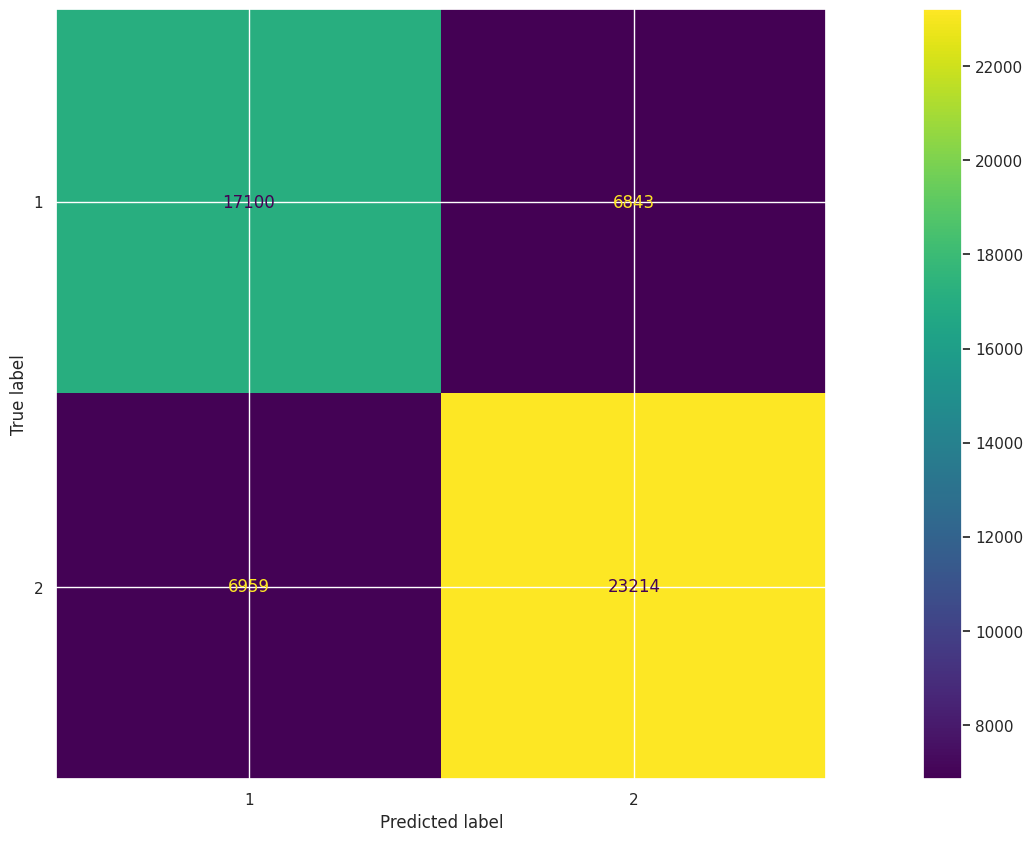

In [ ]:
#Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()

#### Parametrización

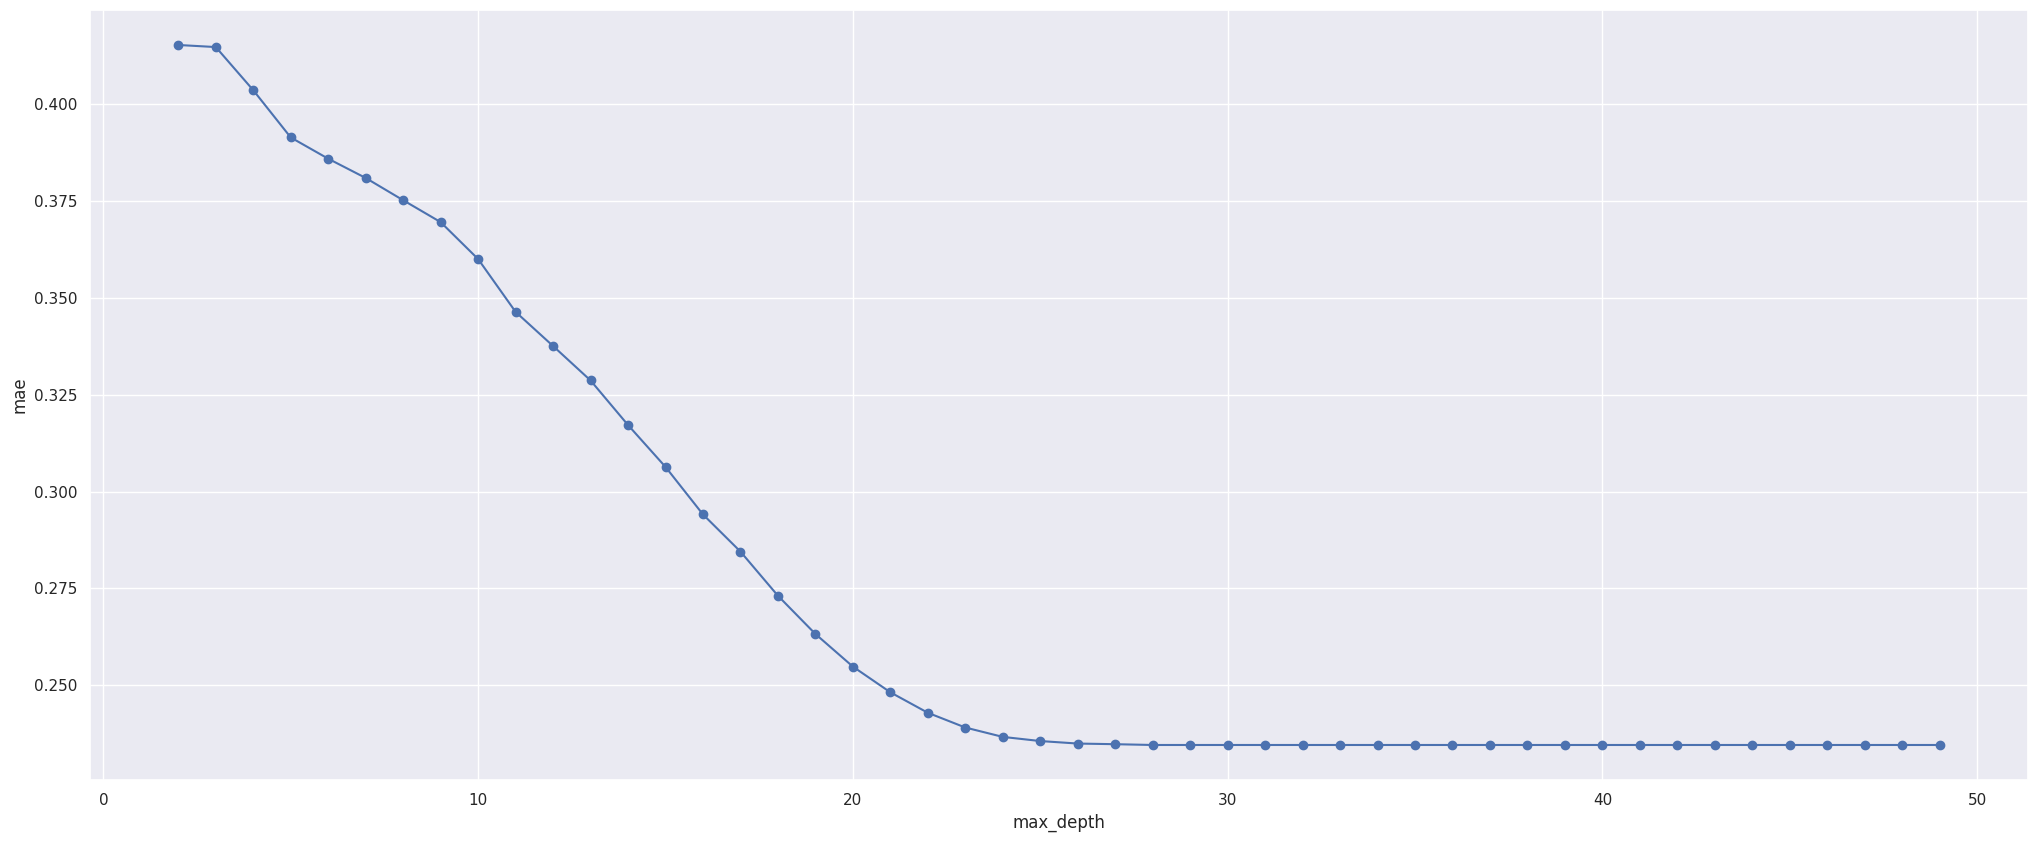

In [ ]:
# Compute the max
mae = []
from sklearn.metrics import mean_absolute_error
for i in range(2, 50):
    model = DecisionTreeClassifier(criterion='gini', max_depth=i)
    model.fit(ohe_n[['Año', 'SemanaAño', #'GrupoNumCapturasBalanceado',
       'IdArteCategoria_1', 'IdArteCategoria_3', 'IdArteCategoria_4', 'IdArteCategoria_5',
       'IdArteCategoria_6', 'IdArteCategoria_8', 'IdArteCategoria_10', 'IdArteCategoria_12',
       'GrupoRE_1', 'GrupoRE_2', 'GrupoRE_3', 'GrupoRE_4',
       'GrupoEslora_1', 'GrupoEslora_2', 'GrupoEslora_3',
       'GrupoEslora_4', 'GrupoEslora_5', 'GrupoEslora_6', 'GrupoEslora_7',
       'GrupoPotencia_1', 'GrupoPotencia_2', 'GrupoPotencia_3',
       'GrupoPotencia_4', 'GrupoPotencia_5']], ohe_n['GrupoNumCapturasBalanceado'])
    pred_values = model.predict(ohe_n[['Año', 'SemanaAño', #'GrupoNumCapturasBalanceado',
       'IdArteCategoria_1', 'IdArteCategoria_3', 'IdArteCategoria_4', 'IdArteCategoria_5',
       'IdArteCategoria_6', 'IdArteCategoria_8', 'IdArteCategoria_10', 'IdArteCategoria_12',
       'GrupoRE_1', 'GrupoRE_2', 'GrupoRE_3', 'GrupoRE_4',
       'GrupoEslora_1', 'GrupoEslora_2', 'GrupoEslora_3',
       'GrupoEslora_4', 'GrupoEslora_5', 'GrupoEslora_6', 'GrupoEslora_7',
       'GrupoPotencia_1', 'GrupoPotencia_2', 'GrupoPotencia_3',
       'GrupoPotencia_4', 'GrupoPotencia_5']])
    maev = mean_absolute_error(ohe_n['GrupoNumCapturasBalanceado'],pred_values)
    mae.append(maev)

# Plot mae
plt.plot(range(2,50), mae, marker='o')
plt.xlabel('max_depth')
plt.ylabel('mae')
plt.show()

Max Depth Value 0.61898541855078 (11)


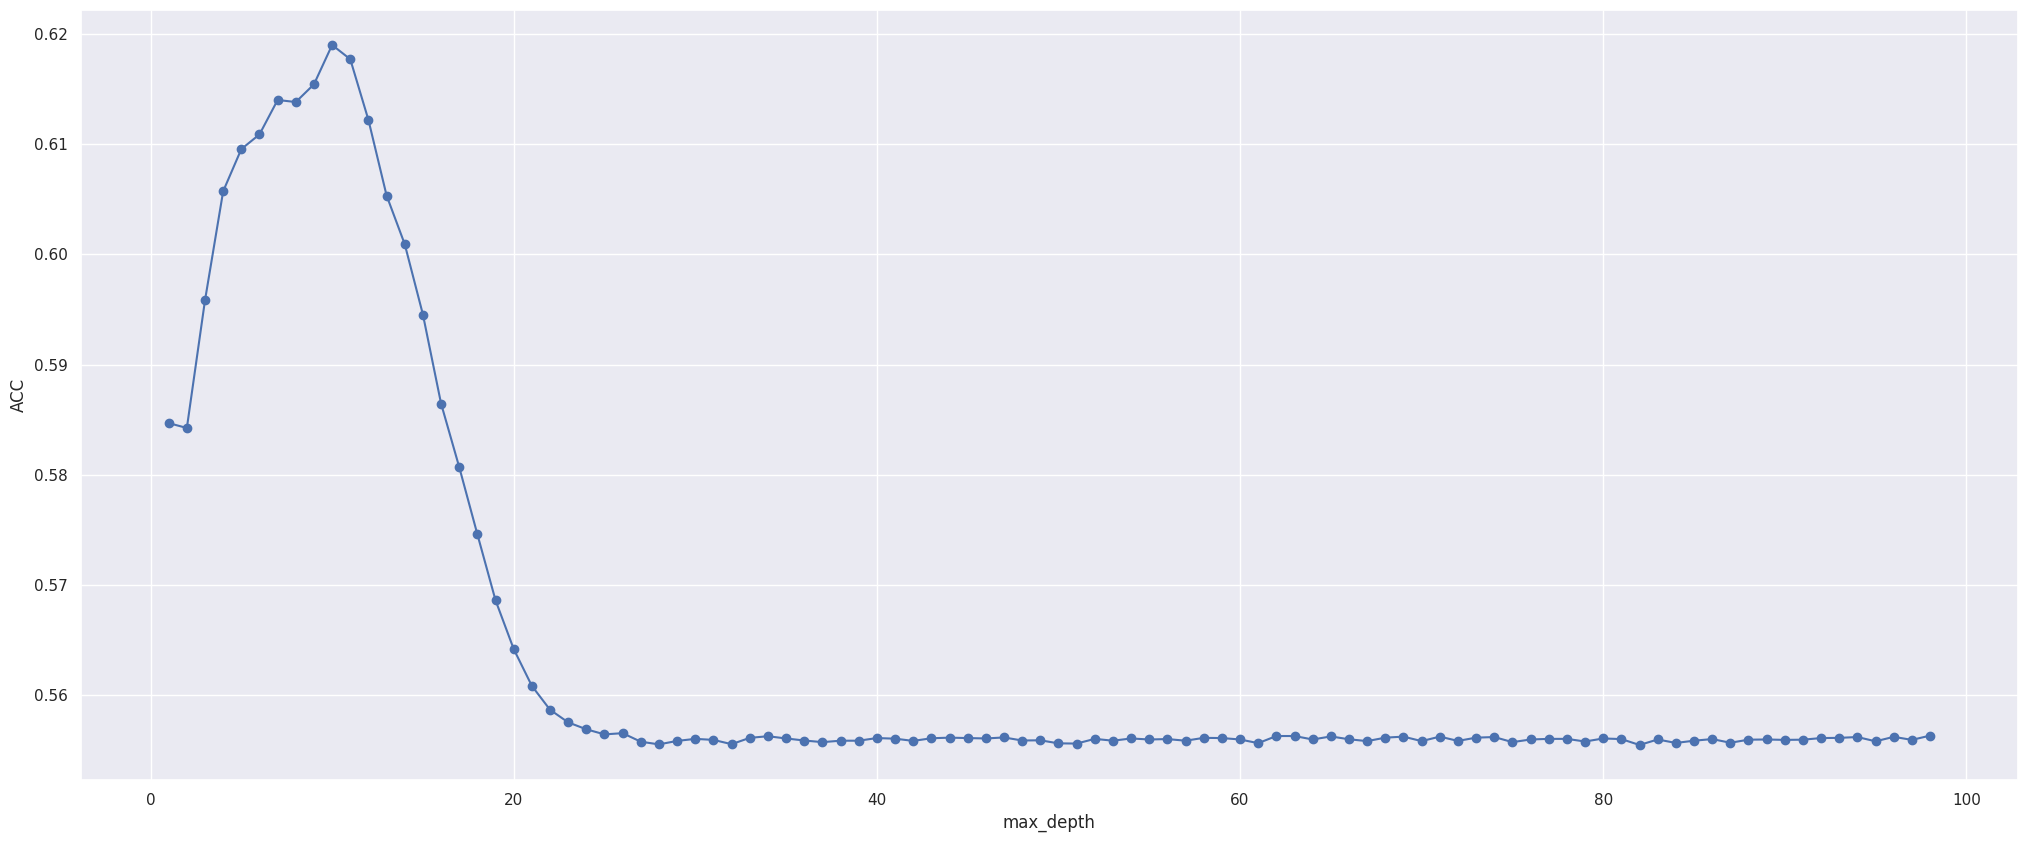

In [ ]:
# CROSS VALIDATION ANALYSIS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

cv = KFold(n_splits = 10, shuffle = True, random_state=rs) #

# reset index
ohe_n.reset_index(drop = True, inplace = True)
ohe_n.head()

total_scores = []
for i in range(2, 100):
   model = DecisionTreeClassifier(criterion='gini', max_depth=i)
   fold_accuracy = []
   for train_fold, test_fold in cv.split(ohe_n):
      # División train test aleatoria
      f_train = ohe_n.loc[train_fold]
      f_test = ohe_n.loc[test_fold]
      # entrenamiento y ejecución del modelo
      model.fit( X = f_train.drop(['GrupoNumCapturasBalanceado'], axis=1), y = f_train['GrupoNumCapturasBalanceado'])
      y_pred = model.predict(X = f_test.drop(['GrupoNumCapturasBalanceado'], axis = 1))
      # evaluación del modelo
      acc = accuracy_score(f_test['GrupoNumCapturasBalanceado'], y_pred)
      fold_accuracy.append(acc)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


max_depth = np.argmax(total_scores) + 2 # +2 porque range(2, 50) y argmax       #Esta línea sería para coger el modelo con el mejor accuracy
# devuelve el índice del vector cuyo valor es máximo, y ese vector está indexado comenzando en 0
print ('Max Depth Value ' + str(max(total_scores)) +" (" + str(max_depth) + ")")


plt.plot(range(1,len(total_scores)+1), total_scores,
         marker='o')
plt.ylabel('ACC')
plt.xlabel('max_depth')
plt.show()

#### Construcción y ejecución del modelo

In [ ]:
# constructor
model = DecisionTreeClassifier(criterion='gini', max_depth = max_depth)
# fit and predict

model.fit( X = ohe_n.drop(['GrupoNumCapturasBalanceado'], axis=1), y = ohe_n['GrupoNumCapturasBalanceado'])
y_pred = model.predict(X = ohe_test_n.drop(['GrupoNumCapturasBalanceado'], axis = 1))
mae = mean_absolute_error(ohe_test_n['GrupoNumCapturasBalanceado'], y_pred)
print ('MAE', mae)
# round the result and cast to int
import numpy as np
res = np.rint(y_pred) # round
res = res.astype(int) # cast to int
# generate output
output = pd.DataFrame({ 'date': ohe_test_n.index, 'result': res})

MAE 0.37705342129090674


In [ ]:
y_true = ohe_test_n['GrupoNumCapturasBalanceado']
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.60      0.44      0.51     10243
           2       0.63      0.77      0.69     12950

    accuracy                           0.62     23193
   macro avg       0.62      0.60      0.60     23193
weighted avg       0.62      0.62      0.61     23193



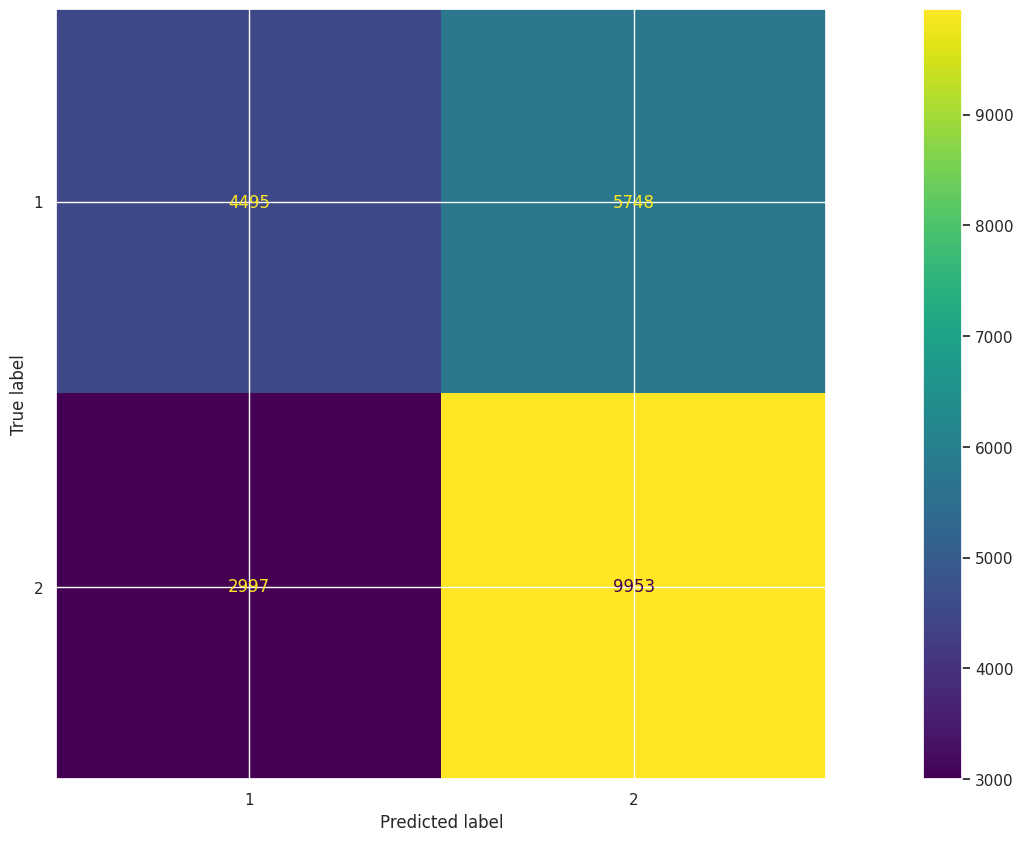

In [ ]:
#Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()

## NÚMERO DE ESPECIES

### Árboles de decisión - NORMALIZADO

In [ ]:
#Se eliminan las variables objetivo no implicadas en este apartado:
ohe2 = ohe.drop(['GrupoNumCapturasBalanceado','PesoTotalCapturado'],axis=1)
ohe_test2 = ohe_test.drop(['GrupoNumCapturasBalanceado','PesoTotalCapturado'],axis=1)
ohe_test2.head()

,Año,SemanaAño,GrupoNumEspecies,IdArteCategoria_1,IdArteCategoria_3,IdArteCategoria_4,IdArteCategoria_5,IdArteCategoria_6,IdArteCategoria_8,IdArteCategoria_10,...,GrupoEslora_3,GrupoEslora_4,GrupoEslora_5,GrupoEslora_6,GrupoEslora_7,GrupoPotencia_1,GrupoPotencia_2,GrupoPotencia_3,GrupoPotencia_4,GrupoPotencia_5
0,2020,16,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2021,4,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,2021,40,1,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,2018,30,2,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2021,17,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
ohe3 = ohe2.drop('GrupoNumEspecies',axis=1)
ohe_test3 = ohe_test2.drop('GrupoNumEspecies',axis=1)
ohe3.head()

,Año,SemanaAño,IdArteCategoria_1,IdArteCategoria_3,IdArteCategoria_4,IdArteCategoria_5,IdArteCategoria_6,IdArteCategoria_8,IdArteCategoria_10,IdArteCategoria_12,...,GrupoEslora_3,GrupoEslora_4,GrupoEslora_5,GrupoEslora_6,GrupoEslora_7,GrupoPotencia_1,GrupoPotencia_2,GrupoPotencia_3,GrupoPotencia_4,GrupoPotencia_5
0,2018,51,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,2019,46,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,2021,25,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,2022,35,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,2020,31,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
#NORMALIZACIÓN
from sklearn.preprocessing import MinMaxScaler
# performin min-max scaling each continuous feature column to the range [0, 1]
scaler = MinMaxScaler()
X_ohe_n = pd.DataFrame(scaler.fit_transform(ohe3[ohe3.columns]),columns=ohe3.columns)
y_ohe_n = pd.DataFrame(ohe2[['GrupoNumEspecies']],columns=['GrupoNumEspecies'])
X_ohe_test_n = pd.DataFrame(scaler.fit_transform(ohe_test3[ohe_test3.columns]),columns=ohe_test3.columns)
y_ohe_test_n = pd.DataFrame(ohe_test2[['GrupoNumEspecies']],columns=['GrupoNumEspecies'])

In [ ]:
ohe_n = pd.concat([X_ohe_n,y_ohe_n],axis=1)
ohe_test_n = pd.concat([X_ohe_test_n,y_ohe_test_n],axis=1)
ohe_n.head()

,Año,SemanaAño,IdArteCategoria_1,IdArteCategoria_3,IdArteCategoria_4,IdArteCategoria_5,IdArteCategoria_6,IdArteCategoria_8,IdArteCategoria_10,IdArteCategoria_12,...,GrupoEslora_4,GrupoEslora_5,GrupoEslora_6,GrupoEslora_7,GrupoPotencia_1,GrupoPotencia_2,GrupoPotencia_3,GrupoPotencia_4,GrupoPotencia_5,GrupoNumEspecies
0,0.00,0.961538,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
1,0.25,0.865385,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2
2,0.75,0.461538,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
3,1.00,0.653846,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
4,0.50,0.576923,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


#### Modelado

In [ ]:
#1.1 Model Parametrization
# criterion: gini
# splitter: best/random
# max_depth: low value avoid overfitting
from sklearn.tree import DecisionTreeClassifier
# model = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=rs)
model = DecisionTreeClassifier(criterion='gini', max_depth=20, random_state=rs)

In [ ]:
#1.2 Model construction
model.fit(ohe_n[['Año', 'SemanaAño', #'GrupoNumCapturasBalanceado',
       'IdArteCategoria_1', 'IdArteCategoria_3', 'IdArteCategoria_4', 'IdArteCategoria_5',
       'IdArteCategoria_6', 'IdArteCategoria_8', 'IdArteCategoria_10', 'IdArteCategoria_12',
       'GrupoRE_1', 'GrupoRE_2', 'GrupoRE_3', 'GrupoRE_4',
       'GrupoEslora_1', 'GrupoEslora_2', 'GrupoEslora_3',
       'GrupoEslora_4', 'GrupoEslora_5', 'GrupoEslora_6', 'GrupoEslora_7',
       'GrupoPotencia_1', 'GrupoPotencia_2', 'GrupoPotencia_3',
       'GrupoPotencia_4', 'GrupoPotencia_5']], ohe_n['GrupoNumEspecies'])

DecisionTreeClassifier(max_depth=20, random_state=0)

In [ ]:
# show classification metrics
from sklearn.metrics import classification_report

y_true = ohe_n['GrupoNumEspecies']
y_pred = model.predict(ohe_n[['Año', 'SemanaAño', #'GrupoNumCapturasBalanceado',
       'IdArteCategoria_1', 'IdArteCategoria_3', 'IdArteCategoria_4', 'IdArteCategoria_5',
       'IdArteCategoria_6', 'IdArteCategoria_8', 'IdArteCategoria_10', 'IdArteCategoria_12',
       'GrupoRE_1', 'GrupoRE_2', 'GrupoRE_3', 'GrupoRE_4',
       'GrupoEslora_1', 'GrupoEslora_2', 'GrupoEslora_3',
       'GrupoEslora_4', 'GrupoEslora_5', 'GrupoEslora_6', 'GrupoEslora_7',
       'GrupoPotencia_1', 'GrupoPotencia_2', 'GrupoPotencia_3',
       'GrupoPotencia_4', 'GrupoPotencia_5']])
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.80      0.90      0.85     28228
           2       0.87      0.76      0.81     25888

    accuracy                           0.83     54116
   macro avg       0.84      0.83      0.83     54116
weighted avg       0.84      0.83      0.83     54116



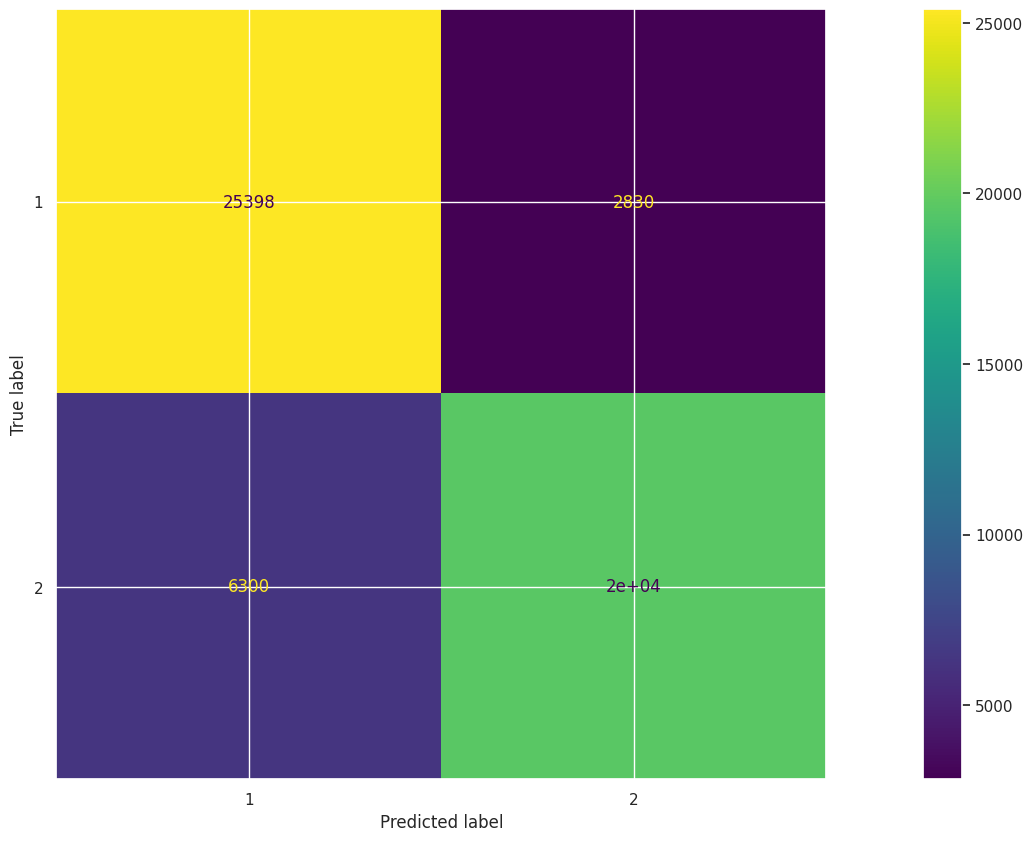

In [ ]:
#Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()

#### Parametrización

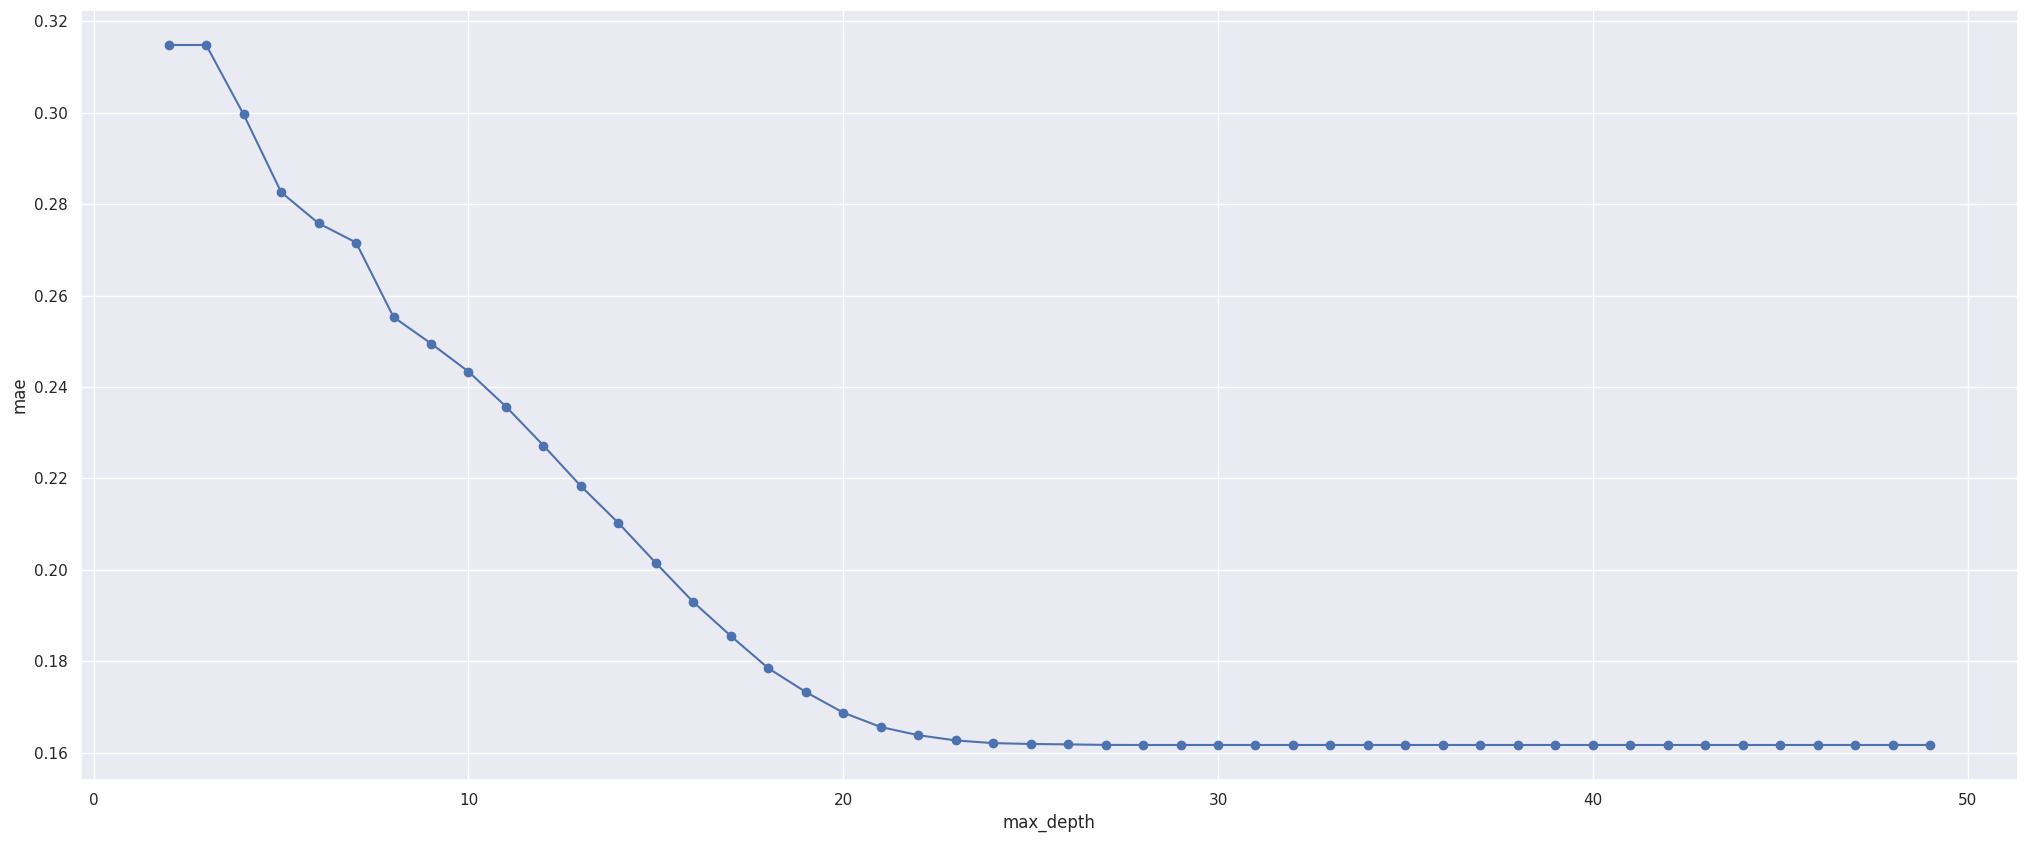

In [ ]:
# Compute the max
mae = []
from sklearn.metrics import mean_absolute_error
for i in range(2, 50):
    model = DecisionTreeClassifier(criterion='gini', max_depth=i)
    model.fit(ohe_n[['Año', 'SemanaAño', #'GrupoNumCapturasBalanceado',
       'IdArteCategoria_1', 'IdArteCategoria_3', 'IdArteCategoria_4', 'IdArteCategoria_5',
       'IdArteCategoria_6', 'IdArteCategoria_8', 'IdArteCategoria_10', 'IdArteCategoria_12',
       'GrupoRE_1', 'GrupoRE_2', 'GrupoRE_3', 'GrupoRE_4',
       'GrupoEslora_1', 'GrupoEslora_2', 'GrupoEslora_3',
       'GrupoEslora_4', 'GrupoEslora_5', 'GrupoEslora_6', 'GrupoEslora_7',
       'GrupoPotencia_1', 'GrupoPotencia_2', 'GrupoPotencia_3',
       'GrupoPotencia_4', 'GrupoPotencia_5']], ohe_n['GrupoNumEspecies'])
    pred_values = model.predict(ohe_n[['Año', 'SemanaAño', #'GrupoNumCapturasBalanceado',
       'IdArteCategoria_1', 'IdArteCategoria_3', 'IdArteCategoria_4', 'IdArteCategoria_5',
       'IdArteCategoria_6', 'IdArteCategoria_8', 'IdArteCategoria_10', 'IdArteCategoria_12',
       'GrupoRE_1', 'GrupoRE_2', 'GrupoRE_3', 'GrupoRE_4',
       'GrupoEslora_1', 'GrupoEslora_2', 'GrupoEslora_3',
       'GrupoEslora_4', 'GrupoEslora_5', 'GrupoEslora_6', 'GrupoEslora_7',
       'GrupoPotencia_1', 'GrupoPotencia_2', 'GrupoPotencia_3',
       'GrupoPotencia_4', 'GrupoPotencia_5']])
    maev = mean_absolute_error(ohe_n['GrupoNumEspecies'],pred_values)
    mae.append(maev)

# Plot mae
plt.plot(range(2,50), mae, marker='o')
plt.xlabel('max_depth')
plt.ylabel('mae')
plt.show()

Max Depth Value 0.7445672211338132 (10)


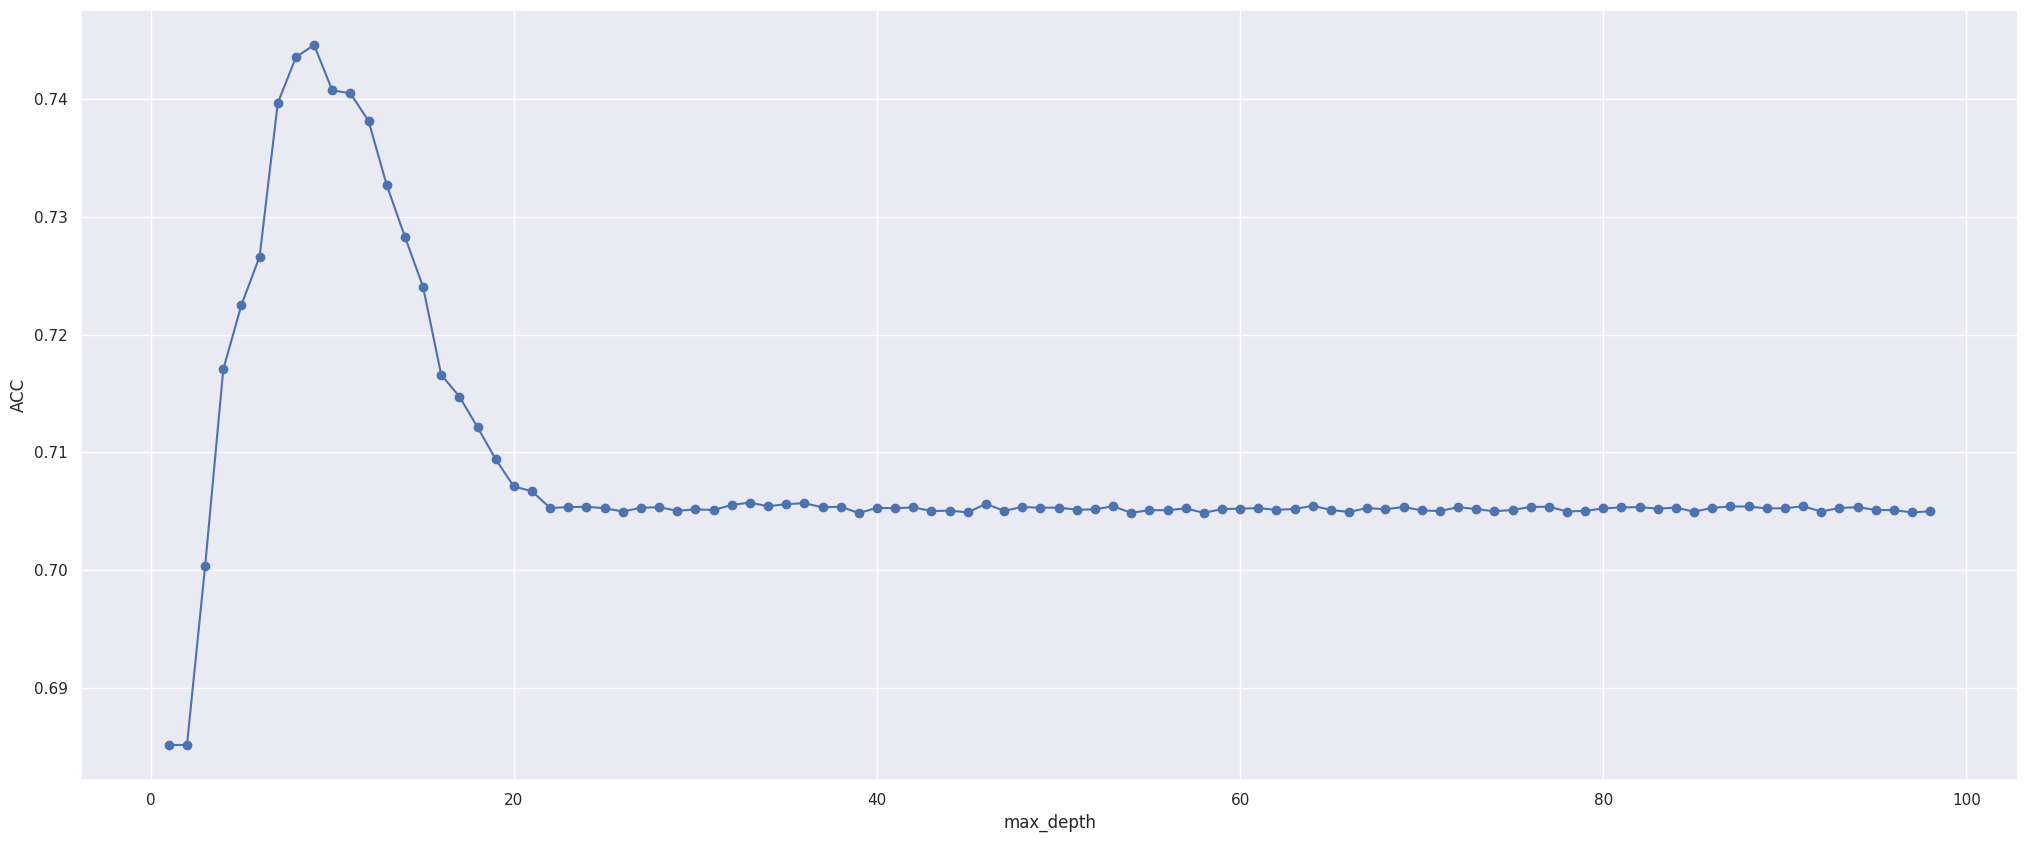

In [ ]:
# CROSS VALIDATION ANALYSIS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

cv = KFold(n_splits = 10, shuffle = True, random_state=rs) #

# reset index
ohe_n.reset_index(drop = True, inplace = True)
ohe_n.head()

total_scores = []
for i in range(2, 100):
   model = DecisionTreeClassifier(criterion='gini', max_depth=i)
   fold_accuracy = []
   for train_fold, test_fold in cv.split(ohe_n):
      # División train test aleatoria
      f_train = ohe_n.loc[train_fold]
      f_test = ohe_n.loc[test_fold]
      # entrenamiento y ejecución del modelo
      model.fit( X = f_train.drop(['GrupoNumEspecies'], axis=1), y = f_train['GrupoNumEspecies'])
      y_pred = model.predict(X = f_test.drop(['GrupoNumEspecies'], axis = 1))
      # evaluación del modelo
      acc = accuracy_score(f_test['GrupoNumEspecies'], y_pred)
      fold_accuracy.append(acc)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


max_depth = np.argmax(total_scores) + 2 # +2 porque range(2, 50) y argmax       #Esta línea sería para coger el modelo con el mejor accuracy
# devuelve el índice del vector cuyo valor es máximo, y ese vector está indexado comenzando en 0
print ('Max Depth Value ' + str(max(total_scores)) +" (" + str(max_depth) + ")")


plt.plot(range(1,len(total_scores)+1), total_scores,
         marker='o')
plt.ylabel('ACC')
plt.xlabel('max_depth')
plt.show()

#### Construcción y ejecución del modelo

In [ ]:
# constructor
model = DecisionTreeClassifier(criterion='gini', max_depth = max_depth)
# fit and predict

model.fit( X = ohe_n.drop(['GrupoNumEspecies'], axis=1), y = ohe_n['GrupoNumEspecies'])
y_pred = model.predict(X = ohe_test_n.drop(['GrupoNumEspecies'], axis = 1))
mae = mean_absolute_error(ohe_test_n['GrupoNumEspecies'], y_pred)
print ('MAE', mae)
# round the result and cast to int
import numpy as np
res = np.rint(y_pred) # round
res = res.astype(int) # cast to int
# generate output
output = pd.DataFrame({ 'date': ohe_test_n.index, 'result': res})

MAE 0.2556805932824559


In [ ]:
y_true = ohe_test_n['GrupoNumEspecies']
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.74      0.79      0.76     12116
           2       0.75      0.70      0.72     11077

    accuracy                           0.74     23193
   macro avg       0.74      0.74      0.74     23193
weighted avg       0.74      0.74      0.74     23193



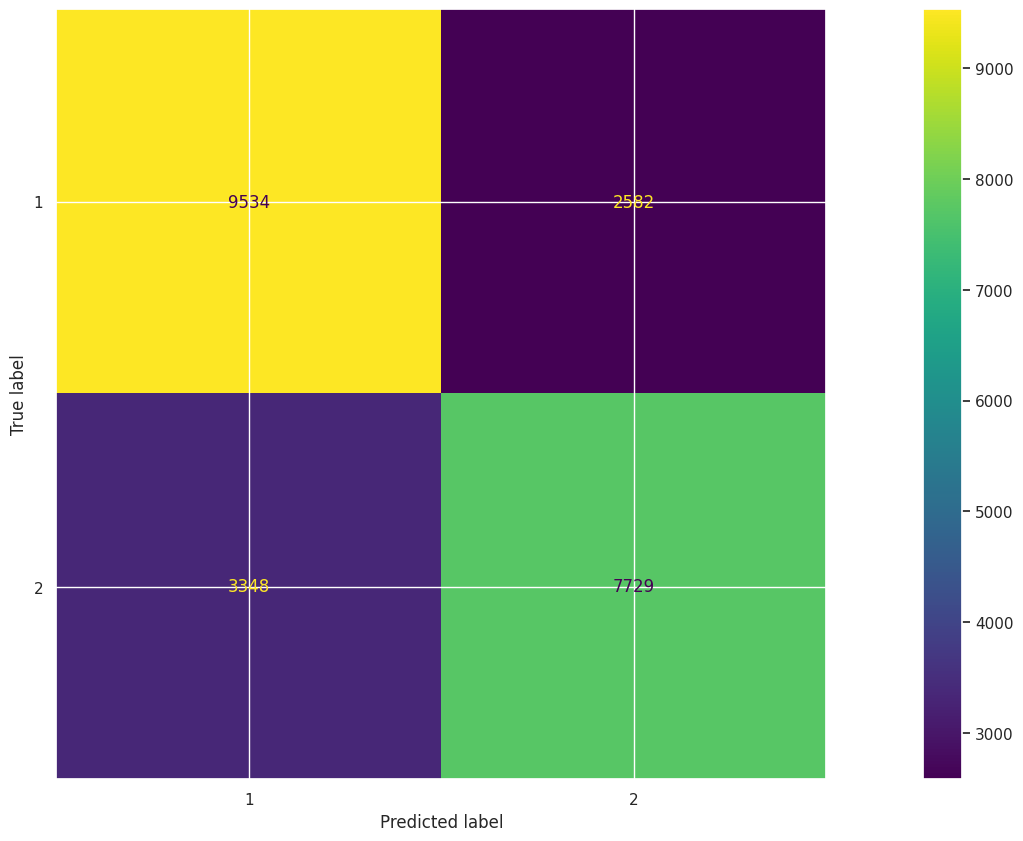

In [ ]:
#Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()